# Behavioral Evaluations & Vector Selection

LLM-as-judge evaluations of steered model generations and vector candidate selection.

**Evaluation Metrics**:
- Coherence scores (1-10 rating)
- Relationship-seeking scores (1-10 rating)
- Pairwise preference rankings (winrates)

**Vector Selection**:
- Steerability analysis across layers
- Coherence vs steerability tradeoff (Pareto frontier)
- Optimal vector selection

In [1]:
import json
import os
import sys
from collections import defaultdict
from io import StringIO
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colorbar as colorbar
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import zscore
from sklearn.metrics import auc

# Add paths for shared imports
REPO_ROOT = Path("../..").resolve()
PROJECT_ROOT = Path("..").resolve()  # 2-steering-vector-training
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(PROJECT_ROOT))

from setup.plot_config import (
    PASTEL2,
    SET2,
    set_pub_style,
    save_fig,
)

# Set paths
VECTOR_DIR = PROJECT_ROOT / "vector"
VECTOR_EVALS_DIR = PROJECT_ROOT / "vector_evals"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
FIGURE_DIR = OUTPUT_DIR / "figures"
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# Apply publication style
set_pub_style()

Publication style loaded (font: Arial)


## Configuration

In [2]:
# Layer configurations for different model sizes
LAYER_CONFIGS = {
    "32": {"layers": [5, 11, 13, 14, 15, 17, 23]},
    "80": {"layers": [9, 15, 21, 27, 29, 31, 33, 35, 41]},
}

# Model name to layer config mapping
SHORT_MODELS = {
    "Llama-3.1-70B-Instruct": "80",
    "Llama-3.1-8B-Instruct": "32",
}

# Display names
MODEL_DISPLAY = {
    "Llama-3.1-70B-Instruct": "Llama-3.1-70B-Instruct",
    "Llama-3.1-8B-Instruct": "Llama-3.1-8B-Instruct",
}

# Multipliers used in generation experiments
MULTIPLIERS = [
    -20,
    -10,
    -5,
    -4,
    -3,
    -2.5,
    -2,
    -1.5,
    -1,
    -0.5,
    0,
    0.5,
    1,
    1.5,
    2,
    2.5,
    3,
    4,
    5,
    10,
    20,
]

# Pairwise comparison multipliers (narrower range)
PAIRWISE_MULTIPLIERS = [-4, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 4]

## Load Evaluation Data

In [3]:
def load_evaluation_data():
    """Load all evaluation data for model-layer-epoch combinations."""
    data = {}

    # Define candidates to load
    candidates = []
    for model_name, n_layers in SHORT_MODELS.items():
        layers = LAYER_CONFIGS[n_layers]["layers"]
        # 70B has epochs 10, 15, 20; 8B has only epoch 20
        epochs = [10, 15, 20] if model_name == "Llama-3.1-70B-Instruct" else [20]
        for epoch in epochs:
            for layer in layers:
                candidates.append({"model": model_name, "layer": layer, "epoch": epoch})

    for c in candidates:
        model = c["model"]
        layer = c["layer"]
        epoch = c["epoch"]
        key = f"{model}-layer{layer}-ep{epoch}"

        experiment_dir = VECTOR_EVALS_DIR / model / f"layer{layer}"
        vec_dir = VECTOR_DIR / f"relationship-seeking_{model}" / f"layer{layer}"

        files = {
            "losses": vec_dir / "evaluation_metrics.jsonl",
            "generations": experiment_dir / f"generations_ep{epoch}.jsonl",
            "coherence": experiment_dir / f"coherence_scores_ep{epoch}.jsonl",
            "relationship": experiment_dir / f"relationship_scores_ep{epoch}.jsonl",
            "pairwise_relationship": experiment_dir
            / f"pairwise_relationship_scores_ep{epoch}.jsonl",
        }

        c_dict = {}
        for data_key, filepath in files.items():
            if filepath.exists():
                try:
                    with open(filepath, "r") as f:
                        df = pd.read_json(StringIO(f.read()), lines=True)
                    if data_key == "losses":
                        df["epoch"] = df["epoch"].map(lambda x: int(np.ceil(x)))
                    c_dict[data_key] = df
                except Exception as e:
                    print(f"Error loading {filepath}: {e}")

        if len(c_dict) > 1:
            c_dict["metadata"] = {"model": model, "layer": layer, "epoch": epoch}
            data[key] = c_dict
            print(f"Loaded {key}")

    return data


data = load_evaluation_data()
print(f"\nLoaded {len(data)} model-layer-epoch combinations")

Loaded Llama-3.1-70B-Instruct-layer9-ep10
Loaded Llama-3.1-70B-Instruct-layer15-ep10
Loaded Llama-3.1-70B-Instruct-layer21-ep10
Loaded Llama-3.1-70B-Instruct-layer27-ep10
Loaded Llama-3.1-70B-Instruct-layer29-ep10
Loaded Llama-3.1-70B-Instruct-layer31-ep10
Loaded Llama-3.1-70B-Instruct-layer33-ep10
Loaded Llama-3.1-70B-Instruct-layer35-ep10
Loaded Llama-3.1-70B-Instruct-layer41-ep10
Loaded Llama-3.1-70B-Instruct-layer9-ep15
Loaded Llama-3.1-70B-Instruct-layer15-ep15
Loaded Llama-3.1-70B-Instruct-layer21-ep15
Loaded Llama-3.1-70B-Instruct-layer27-ep15
Loaded Llama-3.1-70B-Instruct-layer29-ep15
Loaded Llama-3.1-70B-Instruct-layer31-ep15
Loaded Llama-3.1-70B-Instruct-layer33-ep15
Loaded Llama-3.1-70B-Instruct-layer35-ep15
Loaded Llama-3.1-70B-Instruct-layer41-ep15
Loaded Llama-3.1-70B-Instruct-layer9-ep20
Loaded Llama-3.1-70B-Instruct-layer15-ep20
Loaded Llama-3.1-70B-Instruct-layer21-ep20
Loaded Llama-3.1-70B-Instruct-layer27-ep20
Loaded Llama-3.1-70B-Instruct-layer29-ep20
Loaded Llama-3

In [4]:
# Count LLM-as-judge evaluation entries across all model-layer-epoch combinations
total_coherence = 0
total_relationship = 0
total_pairwise = 0

for key, store in data.items():
    if "coherence" in store:
        total_coherence += len(store["coherence"])
    if "relationship" in store:
        total_relationship += len(store["relationship"])
    if "pairwise_relationship" in store:
        total_pairwise += len(store["pairwise_relationship"])

print(f"Total coherence scores: {total_coherence:,}")
print(f"Total relationship scores: {total_relationship:,}")
print(f"Total pairwise comparisons: {total_pairwise:,}")
print(
    f"\nTotal LLM-as-judge evaluations: {total_coherence + total_relationship + total_pairwise:,}"
)

Total coherence scores: 174,930
Total relationship scores: 174,929
Total pairwise comparisons: 874,574

Total LLM-as-judge evaluations: 1,224,433


## Analysis Utilities

In [5]:
def calculate_winrates(df, unique_multipliers):
    """Calculate winrate for each multiplier from pairwise comparisons."""
    wins = defaultdict(int)
    total_matches = defaultdict(int)

    for _, row in df.iterrows():
        if row["model_response"] == "A":
            wins[row["multiplier_a"]] += 1
            total_matches[row["multiplier_a"]] += 1
            total_matches[row["multiplier_b"]] += 1
        else:
            wins[row["multiplier_b"]] += 1
            total_matches[row["multiplier_a"]] += 1
            total_matches[row["multiplier_b"]] += 1

    winrates = {
        m: wins[m] / total_matches[m] if total_matches[m] > 0 else 0
        for m in unique_multipliers
    }
    return pd.Series(winrates)


def calculate_elo(df, unique_multipliers, K=32, initial_rating=1500):
    """Calculate ELO ratings for each multiplier."""
    ratings = {m: initial_rating for m in unique_multipliers}

    def expected_score(rating_a, rating_b):
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

    def update_elo(rating_a, rating_b, actual_score, K=32):
        expected = expected_score(rating_a, rating_b)
        return rating_a + K * (actual_score - expected)

    for _, row in df.iterrows():
        mult_a = row["multiplier_a"]
        mult_b = row["multiplier_b"]
        result = 1 if row["model_response"] == "A" else 0

        rating_a = ratings[mult_a]
        rating_b = ratings[mult_b]

        ratings[mult_a] = update_elo(rating_a, rating_b, result, K)
        ratings[mult_b] = update_elo(rating_b, rating_a, 1 - result, K)

    return pd.Series(ratings)


def calculate_coherence_auc(data, multiplier_range=(-2, 2)):
    """Calculate AUC of coherence scores for each model-layer."""
    aucs = {}
    for key, data_store in data.items():
        if "coherence" not in data_store:
            continue
        df = data_store["coherence"]
        grouped = df.groupby("multiplier")["score"].agg(["mean", "std"]).reset_index()
        grouped = grouped[
            (grouped["multiplier"] >= multiplier_range[0])
            & (grouped["multiplier"] <= multiplier_range[1])
        ]
        if len(grouped) > 1:
            aucs[key] = auc(grouped["multiplier"], grouped["mean"])
    return aucs


def calculate_steerability(
    data, analysis_type="pairwise", multiplier_range=(-2, 2), pairwise_metric="winrates"
):
    """Calculate steerability (slope) for each model-layer."""
    slopes = {}

    for key, data_store in data.items():
        try:
            if analysis_type == "propensity":
                df = data_store["generations"]
                score_col = "propensity"
                grouped = (
                    df.groupby("multiplier")[score_col]
                    .agg(["mean", "std"])
                    .reset_index()
                )
                grouped = grouped[
                    (grouped["multiplier"] >= multiplier_range[0])
                    & (grouped["multiplier"] <= multiplier_range[1])
                ]
                x_values = grouped["multiplier"]
                y_values = grouped["mean"]

            elif analysis_type == "rating":
                df = data_store["relationship"]
                score_col = "score"
                grouped = (
                    df.groupby("multiplier")[score_col]
                    .agg(["mean", "std"])
                    .reset_index()
                )
                grouped = grouped[
                    (grouped["multiplier"] >= multiplier_range[0])
                    & (grouped["multiplier"] <= multiplier_range[1])
                ]
                x_values = grouped["multiplier"]
                y_values = grouped["mean"]

            elif analysis_type == "pairwise":
                df = data_store["pairwise_relationship"]
                multipliers = [
                    m
                    for m in PAIRWISE_MULTIPLIERS
                    if m >= multiplier_range[0] and m <= multiplier_range[1]
                ]
                df = df[
                    df["multiplier_a"].isin(multipliers)
                    & df["multiplier_b"].isin(multipliers)
                ]

                if pairwise_metric == "winrates":
                    scores_series = calculate_winrates(df, multipliers)
                elif pairwise_metric == "elo":
                    scores_series = calculate_elo(df, multipliers)
                else:
                    raise ValueError("Invalid pairwise metric")

                scores = scores_series.reset_index()
                scores.columns = ["multiplier", "score"]
                x_values = scores["multiplier"]
                y_values = scores["score"]

            slope, _, _, _, _ = stats.linregress(x_values, y_values)
            slopes[key] = slope

        except Exception as e:
            continue

    return slopes

## Behavioral Evaluation Plots

In [6]:
def plot_behavioral_evals(
    data,
    model="Llama-3.1-70B-Instruct",
    multiplier_range=(-2, 2),
    figsize=(20, 20),
):
    """
    Plot coherence + relationship ratings (wide panels) and winrates (narrow panels).

    Layout: Rows = layers, Columns = epochs (each with rating + ranking panels)
    """

    def get_stars(p_value):
        if p_value < 0.001:
            return "***"
        elif p_value < 0.01:
            return "**"
        elif p_value < 0.05:
            return "*"
        return ""

    n_layers = SHORT_MODELS[model]
    layers = LAYER_CONFIGS[n_layers]["layers"]
    EPOCHS = [10, 15, 20] if model == "Llama-3.1-70B-Instruct" else [20]

    n_rows = len(layers)
    n_cols = len(EPOCHS) * 2

    fig = plt.figure(figsize=figsize)
    width_ratios = [2, 1] * len(EPOCHS)
    gs = fig.add_gridspec(
        n_rows, n_cols, width_ratios=width_ratios, hspace=0.3, wspace=0.15
    )

    # Colors
    coherence_color = "blue"
    relationship_color = "green"
    winrate_color = "red"

    # Store axes for sharing x-axis
    wide_axes = []
    narrow_axes = []

    for row_idx, layer in enumerate(layers):
        for epoch_idx, epoch in enumerate(EPOCHS):
            data_key = f"{model}-layer{layer}-ep{epoch}"
            if data_key not in data:
                continue

            wide_col = epoch_idx * 2
            narrow_col = epoch_idx * 2 + 1

            # === WIDE PANEL: Coherence + Relationship ===
            # Share x-axis with first wide panel in same column
            if row_idx == 0:
                ax_wide = fig.add_subplot(gs[row_idx, wide_col])
            else:
                ax_wide = fig.add_subplot(
                    gs[row_idx, wide_col], sharex=wide_axes[epoch_idx]
                )

            if row_idx == 0:
                wide_axes.append(ax_wide)

            # Plot coherence
            coh_data = data[data_key]["coherence"]
            coh_data = coh_data[
                (coh_data["multiplier"] >= multiplier_range[0])
                & (coh_data["multiplier"] <= multiplier_range[1])
            ]
            grouped_coh = (
                coh_data.groupby("multiplier")["score"]
                .agg(["mean", "std"])
                .reset_index()
            )

            ax_wide.plot(
                grouped_coh["multiplier"],
                grouped_coh["mean"],
                color=coherence_color,
                marker="o",
                alpha=0.8,
                linewidth=2,
                markersize=6,
            )
            ax_wide.fill_between(
                grouped_coh["multiplier"],
                grouped_coh["mean"] - grouped_coh["std"],
                grouped_coh["mean"] + grouped_coh["std"],
                alpha=0.2,
                color=coherence_color,
            )
            auc_coh = auc(grouped_coh["multiplier"], grouped_coh["mean"])

            # Plot relationship
            rel_data = data[data_key]["relationship"]
            rel_data = rel_data[
                (rel_data["multiplier"] >= multiplier_range[0])
                & (rel_data["multiplier"] <= multiplier_range[1])
            ]
            grouped_rel = (
                rel_data.groupby("multiplier")["score"]
                .agg(["mean", "std"])
                .reset_index()
            )

            ax_wide.plot(
                grouped_rel["multiplier"],
                grouped_rel["mean"],
                color=relationship_color,
                marker="s",
                alpha=0.8,
                linewidth=2,
                markersize=6,
            )
            ax_wide.fill_between(
                grouped_rel["multiplier"],
                grouped_rel["mean"] - grouped_rel["std"],
                grouped_rel["mean"] + grouped_rel["std"],
                alpha=0.2,
                color=relationship_color,
            )

            # Regression line for relationship
            slope_rel, intercept_rel, _, p_rel, _ = stats.linregress(
                grouped_rel["multiplier"], grouped_rel["mean"]
            )
            ax_wide.plot(
                grouped_rel["multiplier"],
                slope_rel * grouped_rel["multiplier"] + intercept_rel,
                linestyle="--",
                color="black",
                alpha=0.5,
            )

            # Styling
            ax_wide.set_ylim(0, 10)
            ax_wide.set_xlim(multiplier_range)

            # Annotation boxes with colored border and semi-opaque white background
            bbox_coh = dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=coherence_color,
                alpha=0.8,
                linewidth=1.5,
            )
            bbox_rel = dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=relationship_color,
                alpha=0.8,
                linewidth=1.5,
            )

            ax_wide.text(
                0.97,
                0.35,
                f"AUC: {auc_coh:.2f}",
                transform=ax_wide.transAxes,
                color=coherence_color,
                ha="right",
                va="top",
                fontsize=10,
                bbox=bbox_coh,
            )
            ax_wide.text(
                0.97,
                0.18,
                f"$\\beta$: {slope_rel:.2f}{get_stars(p_rel)}",
                transform=ax_wide.transAxes,
                color=relationship_color,
                ha="right",
                va="top",
                fontsize=10,
                bbox=bbox_rel,
            )

            if row_idx == 0:
                ax_wide.set_title("Rating")
            if epoch_idx == 0:
                ax_wide.set_ylabel(f"Layer {layer}\n\nRating (1-10)")
            else:
                ax_wide.tick_params(labelleft=False)

            # Only show x-axis labels on bottom row
            if row_idx == len(layers) - 1:
                ax_wide.set_xlabel(r"Multiplier ($\lambda$)")
            else:
                ax_wide.tick_params(labelbottom=False)

            # === NARROW PANEL: Winrate ===
            # Share x-axis with first narrow panel in same column
            if row_idx == 0:
                ax_narrow = fig.add_subplot(gs[row_idx, narrow_col])
            else:
                ax_narrow = fig.add_subplot(
                    gs[row_idx, narrow_col], sharex=narrow_axes[epoch_idx]
                )

            if row_idx == 0:
                narrow_axes.append(ax_narrow)

            pairwise_df = data[data_key]["pairwise_relationship"]
            pairwise_df = pairwise_df[
                (pairwise_df["multiplier_a"] >= multiplier_range[0])
                & (pairwise_df["multiplier_a"] <= multiplier_range[1])
                & (pairwise_df["multiplier_b"] >= multiplier_range[0])
                & (pairwise_df["multiplier_b"] <= multiplier_range[1])
            ]
            subset_mults = [
                m
                for m in PAIRWISE_MULTIPLIERS
                if m >= multiplier_range[0] and m <= multiplier_range[1]
            ]
            winrates = calculate_winrates(pairwise_df, subset_mults)
            scores = winrates.reset_index()
            scores.columns = ["multiplier", "score"]

            ax_narrow.plot(
                scores["multiplier"],
                scores["score"],
                color=winrate_color,
                marker="^",
                linewidth=2,
                markersize=8,
                alpha=0.8,
            )

            slope_win, intercept_win, _, p_win, _ = stats.linregress(
                scores["multiplier"], scores["score"]
            )
            ax_narrow.plot(
                scores["multiplier"],
                slope_win * scores["multiplier"] + intercept_win,
                linestyle="--",
                color="black",
                alpha=0.5,
            )

            ax_narrow.set_ylim(0, 1)
            ax_narrow.set_xlim(multiplier_range)
            ax_narrow.yaxis.tick_right()
            ax_narrow.yaxis.set_label_position("right")

            # Annotation box for winrate beta
            bbox_win = dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=winrate_color,
                alpha=0.8,
                linewidth=1.5,
            )

            ax_narrow.text(
                0.95,
                0.18,
                f"$\\beta$: {slope_win:.2f}{get_stars(p_win)}",
                transform=ax_narrow.transAxes,
                color=winrate_color,
                ha="right",
                va="top",
                fontsize=10,
                bbox=bbox_win,
            )

            if row_idx == 0:
                ax_narrow.set_title("Ranking")
            if epoch_idx == len(EPOCHS) - 1:
                ax_narrow.set_ylabel(
                    "Winrate", rotation=270, va="bottom", color=winrate_color
                )
            else:
                ax_narrow.tick_params(labelright=False)

            # Only show x-axis labels on bottom row
            if row_idx == len(layers) - 1:
                ax_narrow.set_xlabel(r"$\lambda$")
            else:
                ax_narrow.tick_params(labelbottom=False)

    # Epoch labels (larger font to match axis titles)
    for epoch_idx, epoch in enumerate(EPOCHS):
        wide_col = epoch_idx * 2
        narrow_col = epoch_idx * 2 + 1
        ax_wide = fig.axes[wide_col]
        ax_narrow = fig.axes[narrow_col]
        wide_bbox = ax_wide.get_position()
        narrow_bbox = ax_narrow.get_position()
        x_pos = (wide_bbox.x0 + narrow_bbox.x1) / 2
        fig.text(
            x_pos, 0.92, f"Epoch {epoch}", ha="center", fontsize=18, fontweight="bold"
        )

    # Legend
    legend_handles = [
        mlines.Line2D([], [], color=coherence_color, marker="o", label="Coherence"),
        mlines.Line2D(
            [], [], color=relationship_color, marker="s", label="Relationship-Seeking"
        ),
        mlines.Line2D([], [], color=winrate_color, marker="^", label="Winrate"),
    ]
    fig.legend(
        handles=legend_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.05),
        ncol=3,
        markerscale=2,
    )

    plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.90])

    return fig

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_50713/1743828070.py:311: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.90])


Saved: behavioral_evals_70B


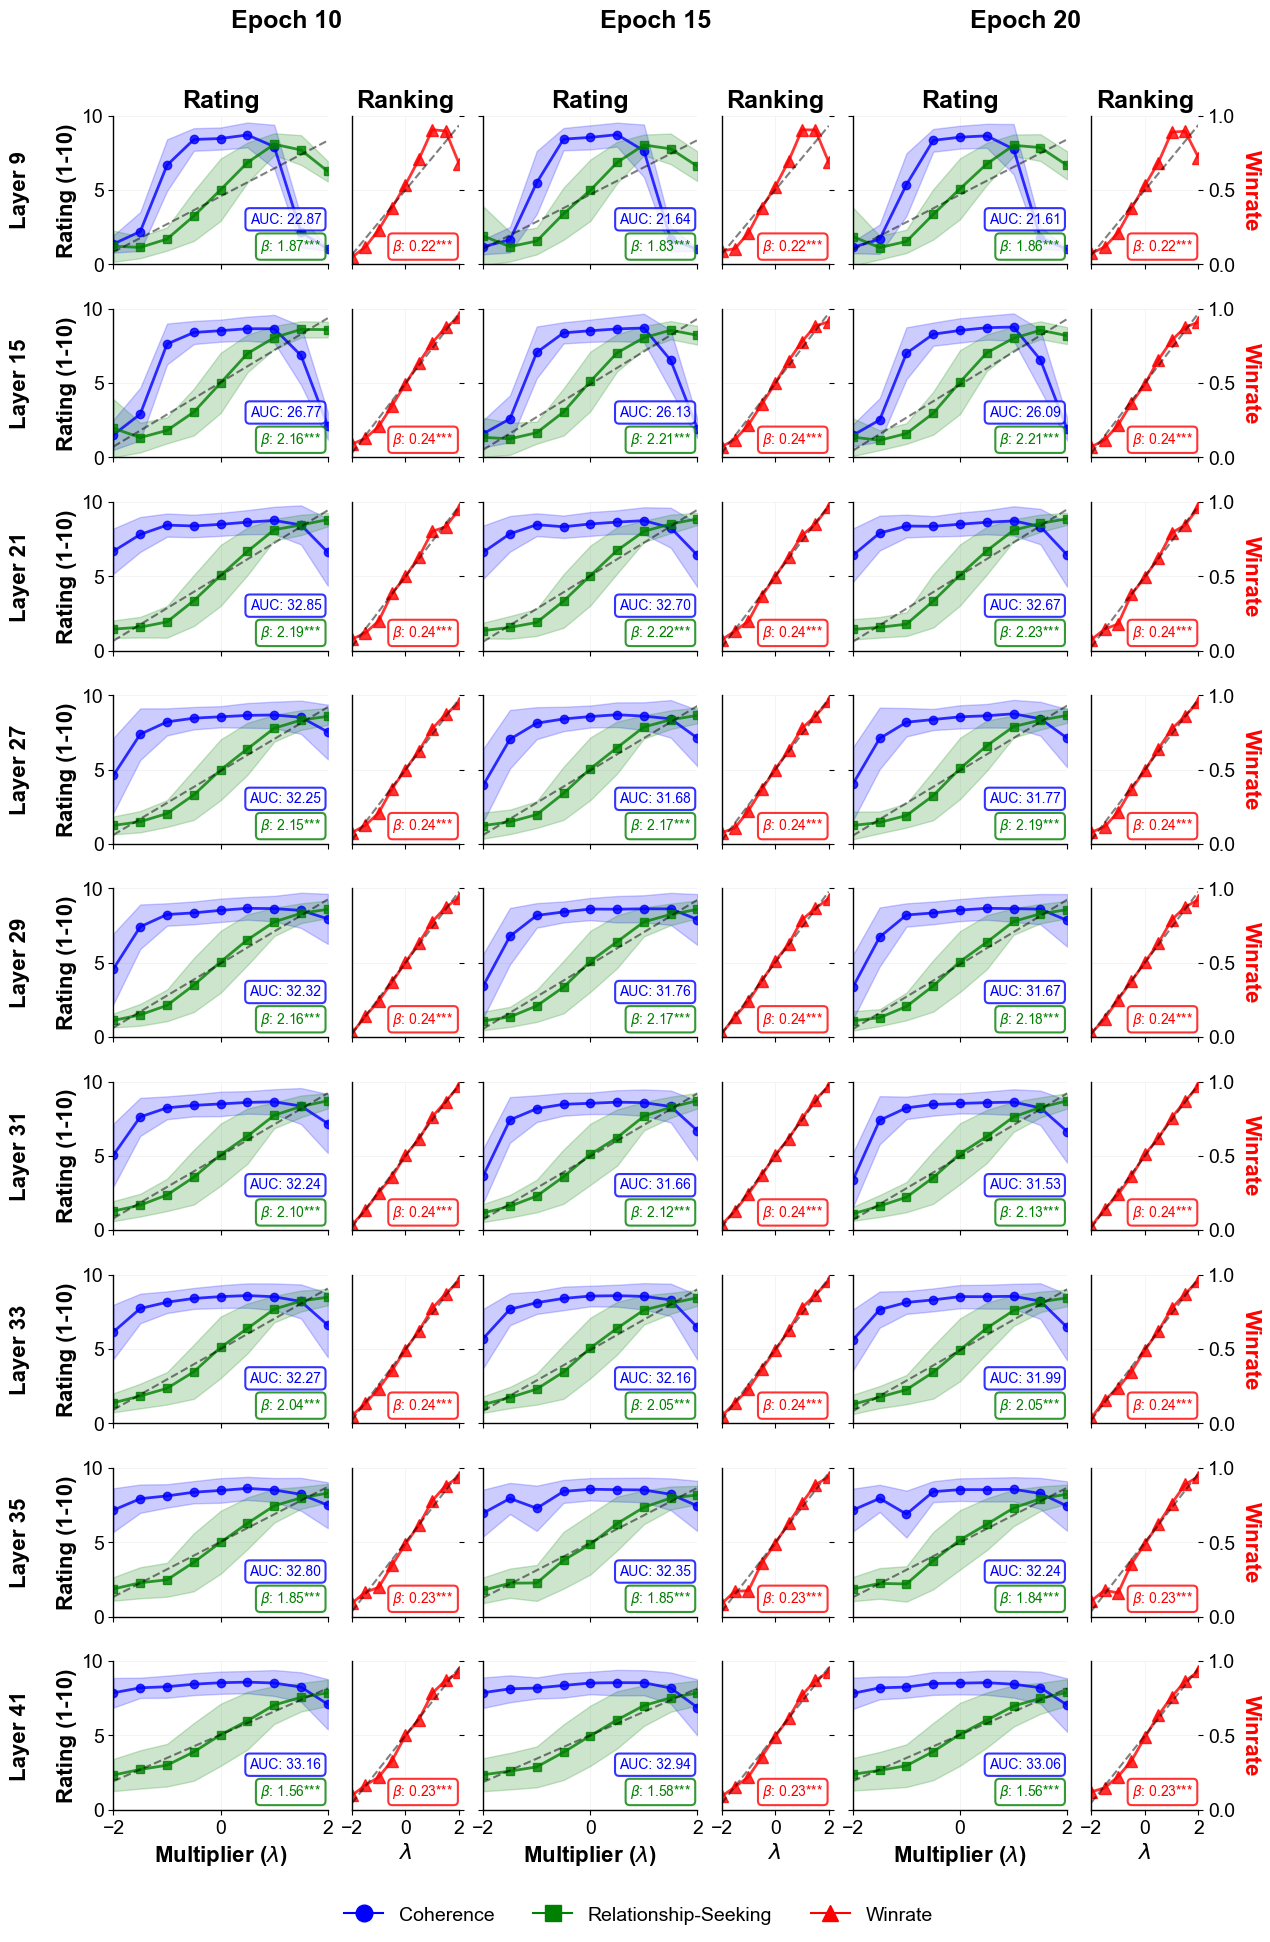

In [7]:
# Plot for 70B model
fig_70b = plot_behavioral_evals(
    data, model="Llama-3.1-70B-Instruct", multiplier_range=(-2, 2), figsize=(14, 22)
)
save_fig(fig_70b, FIGURE_DIR, "behavioral_evals_70B")
plt.show()

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_50713/1743828070.py:311: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.90])


Saved: behavioral_evals_8B


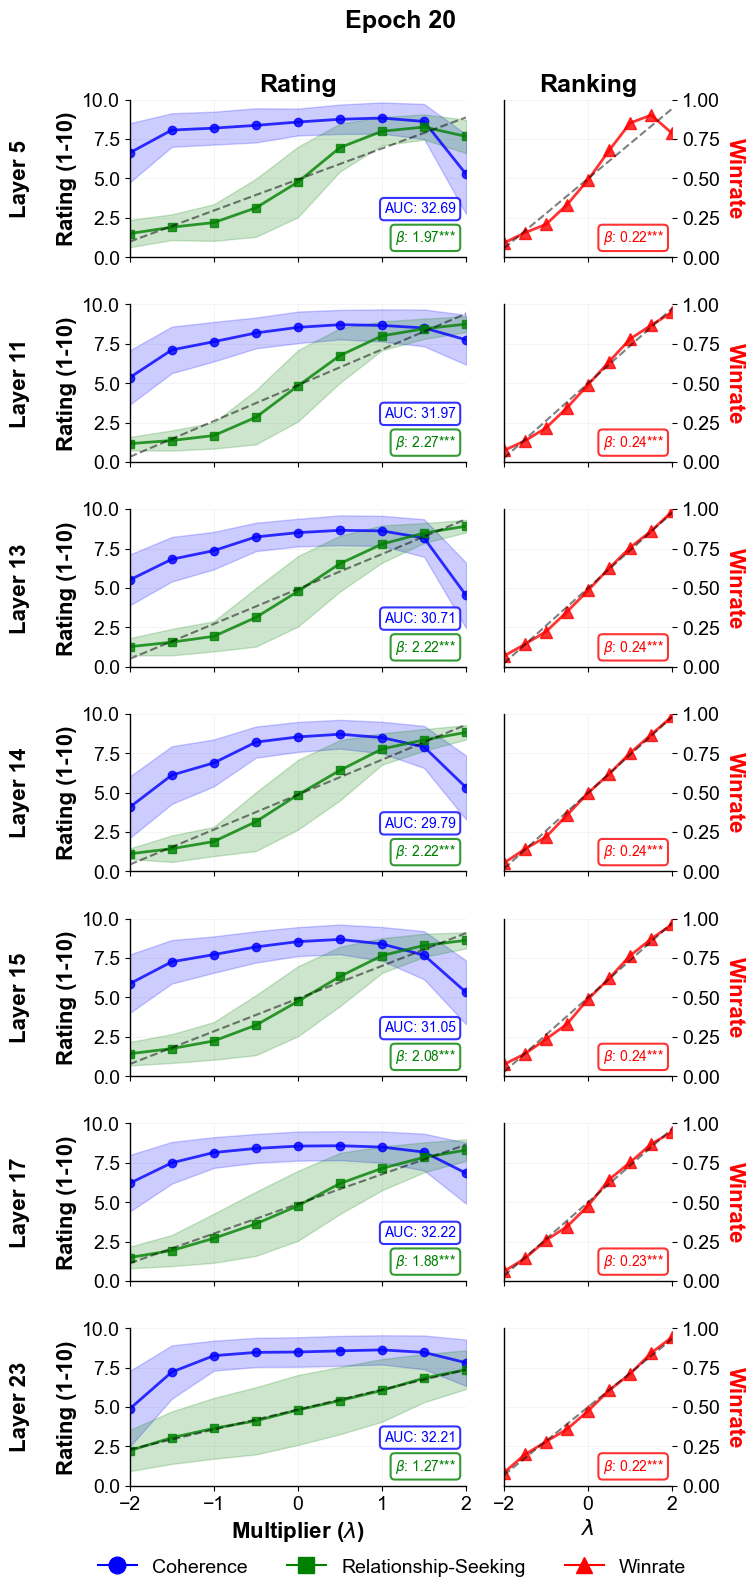

In [8]:
# Plot for 8B model
fig_8b = plot_behavioral_evals(
    data, model="Llama-3.1-8B-Instruct", multiplier_range=(-2, 2), figsize=(7, 18)
)
save_fig(fig_8b, FIGURE_DIR, "behavioral_evals_8B")
plt.show()

## Vector Candidate Selection

In [9]:
# Calculate metrics for all candidates
multiplier_range = (-2, 2)

aucs = calculate_coherence_auc(data, multiplier_range)
pairwise_slopes = calculate_steerability(
    data,
    analysis_type="pairwise",
    pairwise_metric="winrates",
    multiplier_range=multiplier_range,
)
elo_slopes = calculate_steerability(
    data,
    analysis_type="pairwise",
    pairwise_metric="elo",
    multiplier_range=multiplier_range,
)
rating_slopes = calculate_steerability(
    data, analysis_type="rating", multiplier_range=multiplier_range
)
propensity_slopes = calculate_steerability(
    data, analysis_type="propensity", multiplier_range=multiplier_range
)

# Combine metrics
combined_metrics = {}
for key in data.keys():
    try:
        combined_metrics[key] = {
            "auc": aucs.get(key),
            "pairwise_slope": pairwise_slopes.get(key),
            "elo_slope": elo_slopes.get(key),
            "rating_slope": rating_slopes.get(key),
            "propensity_slope": propensity_slopes.get(key),
        }
    except:
        continue

metrics_df = pd.DataFrame(combined_metrics).T
metrics_df = metrics_df.dropna(subset=["auc", "pairwise_slope"])

# Add metadata
for i, row in metrics_df.iterrows():
    metadata = data[i]["metadata"]
    for key, value in metadata.items():
        metrics_df.loc[i, key] = value

metrics_df = metrics_df.reset_index()
metrics_df.columns = ["model_layer"] + list(metrics_df.columns[1:])
metrics_df["model_epoch"] = (
    metrics_df["model"] + "-ep" + metrics_df["epoch"].astype(int).astype(str)
)

print(f"Metrics calculated for {len(metrics_df)} candidates")
metrics_df.head()

Metrics calculated for 34 candidates


,model_layer,auc,pairwise_slope,elo_slope,rating_slope,propensity_slope,model,layer,epoch,model_epoch
0,Llama-3.1-70B-Instruct-layer9-ep10,22.869388,0.217721,439.708386,1.873197,1.969590,Llama-3.1-70B-Instruct,9.0,10.0,Llama-3.1-70B-Instruct-ep10
1,Llama-3.1-70B-Instruct-layer15-ep10,26.765306,0.235578,501.481660,2.160680,1.501530,Llama-3.1-70B-Instruct,15.0,10.0,Llama-3.1-70B-Instruct-ep10
2,Llama-3.1-70B-Instruct-layer21-ep10,32.848980,0.236463,515.344930,2.194558,0.652601,Llama-3.1-70B-Instruct,21.0,10.0,Llama-3.1-70B-Instruct-ep10
3,Llama-3.1-70B-Instruct-layer27-ep10,32.252041,0.237058,505.982985,2.148299,0.837733,Llama-3.1-70B-Instruct,27.0,10.0,Llama-3.1-70B-Instruct-ep10
4,Llama-3.1-70B-Instruct-layer29-ep10,32.323469,0.239456,521.366669,2.156327,0.850116,Llama-3.1-70B-Instruct,29.0,10.0,Llama-3.1-70B-Instruct-ep10


### Steerability by Layer

Saved: steerability_by_layer


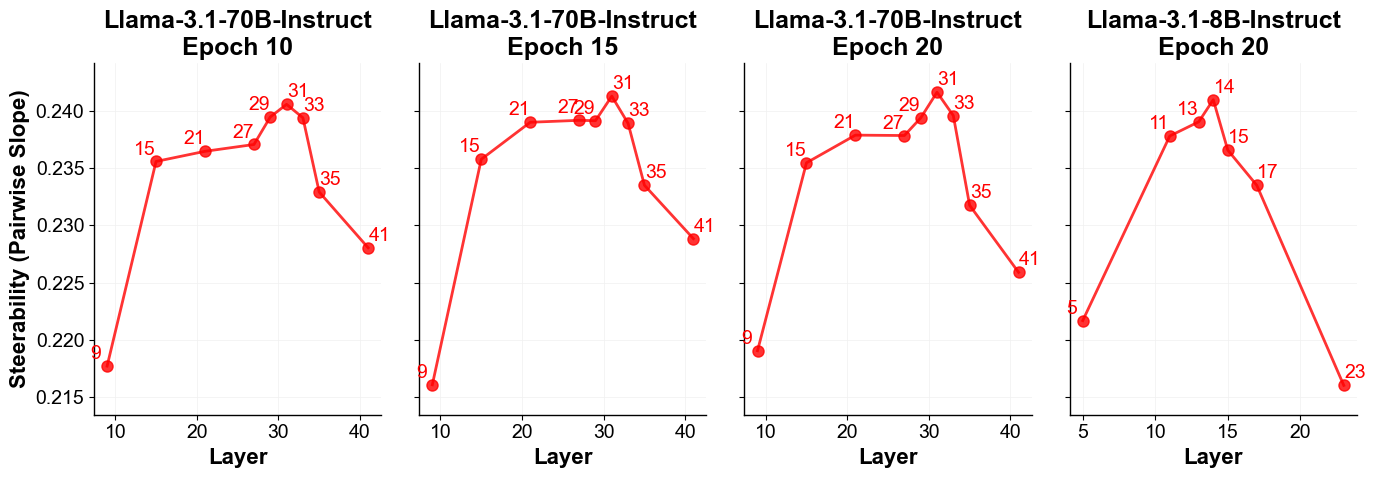

In [10]:
def plot_steerability_by_layer(metrics_df):
    """Plot steerability (pairwise slope) by layer for each model-epoch."""
    comparisons = metrics_df["model_epoch"].unique()

    fig, axes = plt.subplots(1, len(comparisons), figsize=(14, 5), sharey=True)
    if len(comparisons) == 1:
        axes = [axes]

    winrate_color = "red"

    for i, modelep in enumerate(comparisons):
        subset = metrics_df[metrics_df["model_epoch"] == modelep]
        ax = axes[i]

        is_8b = "8B" in modelep
        layer_threshold = 14 if is_8b else 31

        ax.plot(
            subset["layer"],
            subset["pairwise_slope"],
            marker="o",
            color=winrate_color,
            linewidth=2,
            markersize=8,
            alpha=0.8,
        )

        # Title formatting
        parts = modelep.split("-ep")
        title = (
            f"{parts[0]}\nEpoch {int(float(parts[1]))}" if len(parts) == 2 else modelep
        )
        ax.set_title(title)
        ax.set_xlabel("Layer")

        if i == 0:
            ax.set_ylabel("Steerability (Pairwise Slope)")

        # Annotate points
        for x, y in zip(subset["layer"], subset["pairwise_slope"]):
            x_offset = -8 if x < layer_threshold else 8
            ax.annotate(
                f"{int(x)}",
                (x, y),
                textcoords="offset points",
                xytext=(x_offset, 5),
                ha="center",
                color=winrate_color,
            )

        ax.margins(y=0.1)

    plt.tight_layout()
    return fig


fig_steer = plot_steerability_by_layer(metrics_df)
save_fig(fig_steer, FIGURE_DIR, "steerability_by_layer")
plt.show()

### Pareto Frontier Analysis

In [11]:
def select_optimal_model_layers(
    metrics_df, coherence_weight=0.5, steerability_weight=0.5
):
    """
    Select optimal model layers based on coherence (auc) and steerability (pairwise_slope).
    """
    df = metrics_df.copy()

    total = coherence_weight + steerability_weight
    coherence_weight = coherence_weight / total
    steerability_weight = steerability_weight / total

    df["auc_normalized"] = zscore(df["auc"])
    df["pairwise_slope_normalized"] = zscore(df["pairwise_slope"])

    df["score"] = (
        coherence_weight * df["auc_normalized"]
        + steerability_weight * df["pairwise_slope_normalized"]
    )

    df_sorted = df.sort_values("score", ascending=False).reset_index(drop=True)

    return df_sorted


def plot_pareto_frontier(
    metrics_df,
    highlight_top=None,
    coherence_weight=0.5,
    steerability_weight=0.5,
    figsize=(12, 8),
    annotate_all_points=True,
):
    """
    Plot the Pareto frontier for coherence (auc) and steerability (pairwise_slope).
    """
    df = metrics_df.copy()

    points = df[["auc", "pairwise_slope"]].values
    is_pareto = np.ones(len(points), dtype=bool)

    for i, point_i in enumerate(points):
        if not is_pareto[i]:
            continue

        for j, point_j in enumerate(points):
            if i != j and is_pareto[j]:
                if all(point_j >= point_i) and any(point_j > point_i):
                    is_pareto[i] = False
                    break

    pareto_df = df[is_pareto].copy()

    fig, ax = plt.subplots(figsize=figsize)

    special_annotations = {
        ("70B", 15, 15): (7, 15),
        ("70B", 29, 20): (-30, 12),
        ("70B", 27, 15): (-35, 0),
        ("70B", 29, 15): (-35, -30),
        ("70B", 35, 15): (0, -30),
        ("70B", 33, 10): (5, -30),
    }

    cmaps = {
        "70B": plt.cm.winter_r,
        "8B": plt.cm.spring_r,
    }

    df_70b = df[df["model"].str.contains("70B")]
    df_8b = df[df["model"].str.contains("8B")]

    layer_ranges = {
        "70B": (df_70b["layer"].min(), df_70b["layer"].max()),
        "8B": (df_8b["layer"].min(), df_8b["layer"].max()),
    }

    for i, row in df.iterrows():
        model = row["model"]
        epoch = int(row["epoch"])
        layer = int(row["layer"])

        if "8B" in model:
            param = "8B"
        else:
            param = "70B"

        if epoch == 10:
            marker = "s"
        elif epoch == 15:
            marker = "D"
        else:
            marker = "o"

        layer_min, layer_max = layer_ranges[param]
        layer_norm = (layer - layer_min) / (layer_max - layer_min)
        color = cmaps[param](layer_norm)

        edge_color = "red" if i in pareto_df.index else "black"
        edge_width = 2.5 if i in pareto_df.index else 0.5

        z_order = 10 if layer == 29 else 5

        ax.scatter(
            row["auc"],
            row["pairwise_slope"],
            color=color,
            marker=marker,
            s=400,
            alpha=0.8,
            edgecolors=edge_color,
            linewidth=edge_width,
            zorder=z_order,
        )

        should_annotate = annotate_all_points or (i in pareto_df.index)

        if should_annotate:
            point_key = (param, int(layer), epoch)
            if point_key in special_annotations and annotate_all_points:
                x_offset, y_offset = special_annotations[point_key]
                ax.annotate(
                    str(int(layer)),
                    (row["auc"], row["pairwise_slope"]),
                    xytext=(x_offset, y_offset),
                    textcoords="offset points",
                    fontsize=12,
                    fontweight="bold",
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1"),
                    zorder=100,
                )
            else:
                y_range = df["pairwise_slope"].max() - df["pairwise_slope"].min()
                if marker == "D":
                    y_offset = -0.002 * y_range
                elif marker == "o":
                    y_offset = -0.001 * y_range
                else:
                    y_offset = 0

                text_color = "black" if layer_norm < 0.3 else "white"

                ax.text(
                    row["auc"],
                    row["pairwise_slope"] + y_offset,
                    str(int(layer)),
                    fontsize=12,
                    color=text_color,
                    fontweight="bold",
                    ha="center",
                    va="center",
                    zorder=100,
                )

    pareto_df_sorted = pareto_df.sort_values("auc")
    ax.plot(
        pareto_df_sorted["auc"],
        pareto_df_sorted["pairwise_slope"],
        "--",
        color="red",
        linewidth=3,
        label="Pareto Frontier",
    )

    if highlight_top is not None:
        top_df = highlight_top.head(5)

        normalized_coherence_weight = coherence_weight / np.std(df["auc"])
        normalized_steerability_weight = steerability_weight / np.std(
            df["pairwise_slope"]
        )
        slope = -normalized_coherence_weight / normalized_steerability_weight

        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        top_model = top_df.iloc[0]
        intercept = top_model["pairwise_slope"] - slope * top_model["auc"]

        x_vals = np.linspace(x_min, x_max, 100)
        y_vals = slope * x_vals + intercept

    ax.set_xlabel("Coherence (AUC)", fontsize=16, fontweight="bold")
    ax.set_ylabel("Steerability (Pairwise Slope)", fontsize=16, fontweight="bold")

    ax.tick_params(axis="both", which="major", labelsize=14)

    legend_elements = [
        Line2D(
            [0],
            [0],
            color="red",
            linestyle="--",
            linewidth=3,
            label="Pareto Frontier",
        ),
        Line2D(
            [0],
            [0],
            marker="s",
            color="w",
            markerfacecolor="gray",
            markersize=20,
            label="Epoch 10",
            linestyle="None",
        ),
        Line2D(
            [0],
            [0],
            marker="D",
            color="w",
            markerfacecolor="gray",
            markersize=20,
            label="Epoch 15",
            linestyle="None",
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="gray",
            markersize=20,
            label="Epoch 20",
            linestyle="None",
        ),
    ]

    legend = ax.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.08),
        ncol=4,
        fontsize=14,
        frameon=False,
        columnspacing=1.5,
    )

    layers_70b = sorted(df_70b["layer"].unique())
    layers_8b = sorted(df_8b["layer"].unique())

    norm_70b = Normalize(vmin=min(layers_70b), vmax=max(layers_70b))
    norm_8b = Normalize(vmin=min(layers_8b), vmax=max(layers_8b))

    cbar_ax_70b = fig.add_axes([0.2, -0.05, 0.25, 0.02])
    cbar_70b = colorbar.ColorbarBase(
        cbar_ax_70b, cmap=plt.cm.winter_r, norm=norm_70b, orientation="horizontal"
    )
    cbar_70b.set_label(
        "Layer (Llama-3.1-70B-Instruct)", fontsize=12, fontstyle="italic"
    )
    cbar_70b.set_ticks(layers_70b)
    cbar_70b.set_ticklabels([str(int(l)) for l in layers_70b])
    cbar_70b.ax.tick_params(labelsize=10)

    cbar_ax_8b = fig.add_axes([0.55, -0.05, 0.25, 0.02])
    cbar_8b = colorbar.ColorbarBase(
        cbar_ax_8b, cmap=plt.cm.spring_r, norm=norm_8b, orientation="horizontal"
    )
    cbar_8b.set_label("Layer (Llama-3.1-8B-Instruct)", fontsize=12, fontstyle="italic")
    cbar_8b.set_ticks(layers_8b)
    cbar_8b.set_ticklabels([str(int(l)) for l in layers_8b])
    cbar_8b.ax.tick_params(labelsize=10)

    ax.set_title(
        "Steerability vs Coherence Tradeoff",
        fontsize=16,
        fontstyle="italic",
    )
    ax.grid(True, alpha=0.3)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    x_padding = (df["auc"].max() - df["auc"].min()) * 0.02
    y_padding = (df["pairwise_slope"].max() - df["pairwise_slope"].min()) * 0.05
    ax.set_xlim(df["auc"].min() - x_padding, df["auc"].max() + x_padding)
    ax.set_ylim(
        df["pairwise_slope"].min() - y_padding, df["pairwise_slope"].max() + y_padding
    )

    plt.tight_layout()

    return fig

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_50713/3795733689.py:282: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: pareto_frontier


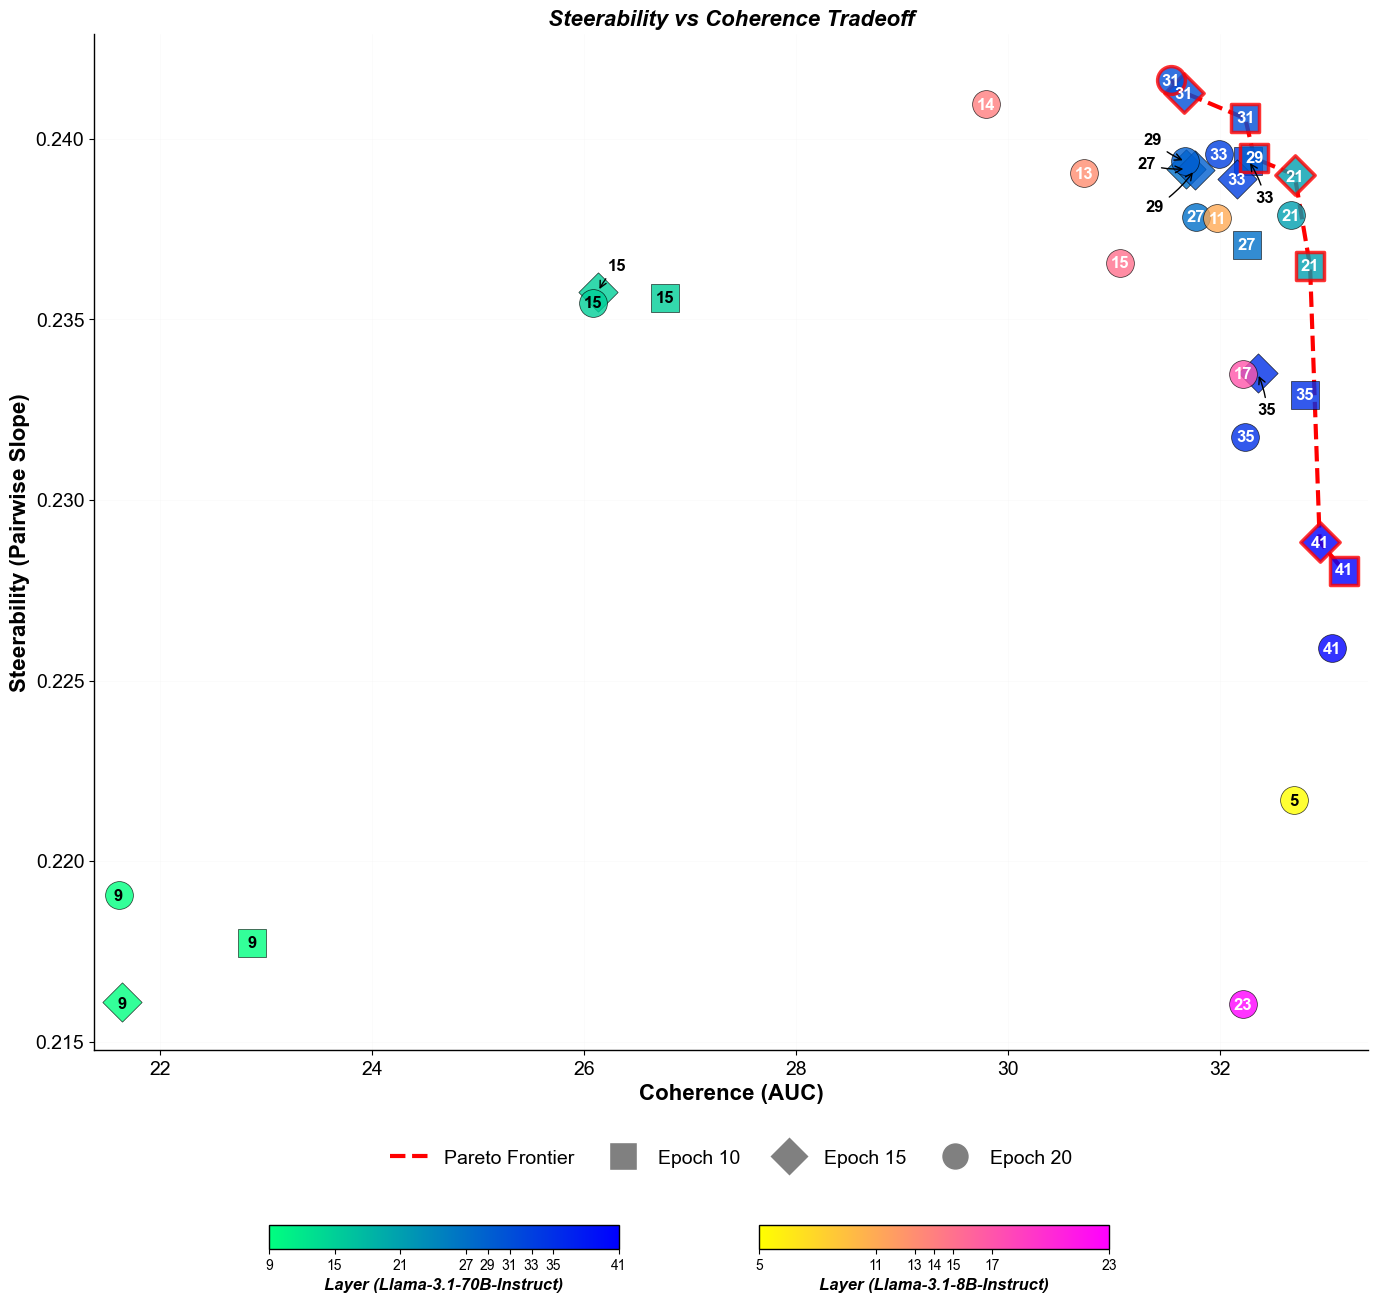

In [12]:
fig_pareto = plot_pareto_frontier(metrics_df, figsize=(14, 12))
save_fig(fig_pareto, FIGURE_DIR, "pareto_frontier")
plt.show()

### Optimal Vector Selection

In [13]:
# Select optimal vector with equal weights
coherence_weight = 0.5
steerability_weight = 0.5

ranked_df = select_optimal_model_layers(
    metrics_df, coherence_weight, steerability_weight
)

top_model = ranked_df.iloc[0]
model_name = top_model["model"]
layer = int(top_model["layer"])
epoch = int(top_model["epoch"])
param = "8B" if "8B" in model_name else "70B"

print("=" * 50)
print("OPTIMAL VECTOR SELECTION")
print("=" * 50)
print(f"Model: {param}-layer{layer}-ep{epoch}")
print(f"Coherence (AUC): {top_model['auc']:.3f}")
print(f"Steerability (Pairwise Slope): {top_model['pairwise_slope']:.3f}")
print(f"Combined Score: {top_model['score']:.3f}")
print(
    f"Weights: Coherence={coherence_weight:.2f}, Steerability={steerability_weight:.2f}"
)
print("=" * 50)

# Show top 5
print("\nTop 5 Candidates:")
display_cols = ["model_layer", "layer", "epoch", "auc", "pairwise_slope", "score"]
print(ranked_df[display_cols].head().to_string(index=False))

OPTIMAL VECTOR SELECTION
Model: 70B-layer31-ep10
Coherence (AUC): 32.238
Steerability (Pairwise Slope): 0.241
Combined Score: 0.679
Weights: Coherence=0.50, Steerability=0.50

Top 5 Candidates:
                        model_layer  layer  epoch       auc  pairwise_slope    score
Llama-3.1-70B-Instruct-layer31-ep10   31.0   10.0 32.237755        0.240561 0.678936
Llama-3.1-70B-Instruct-layer21-ep15   21.0   15.0 32.703061        0.238997 0.647569
Llama-3.1-70B-Instruct-layer31-ep20   31.0   20.0 31.533673        0.241616 0.639472
Llama-3.1-70B-Instruct-layer31-ep15   31.0   15.0 31.659184        0.241276 0.636433
Llama-3.1-70B-Instruct-layer29-ep10   29.0   10.0 32.323469        0.239456 0.619058


### Weight Sensitivity Analysis

Saved: weight_sensitivity


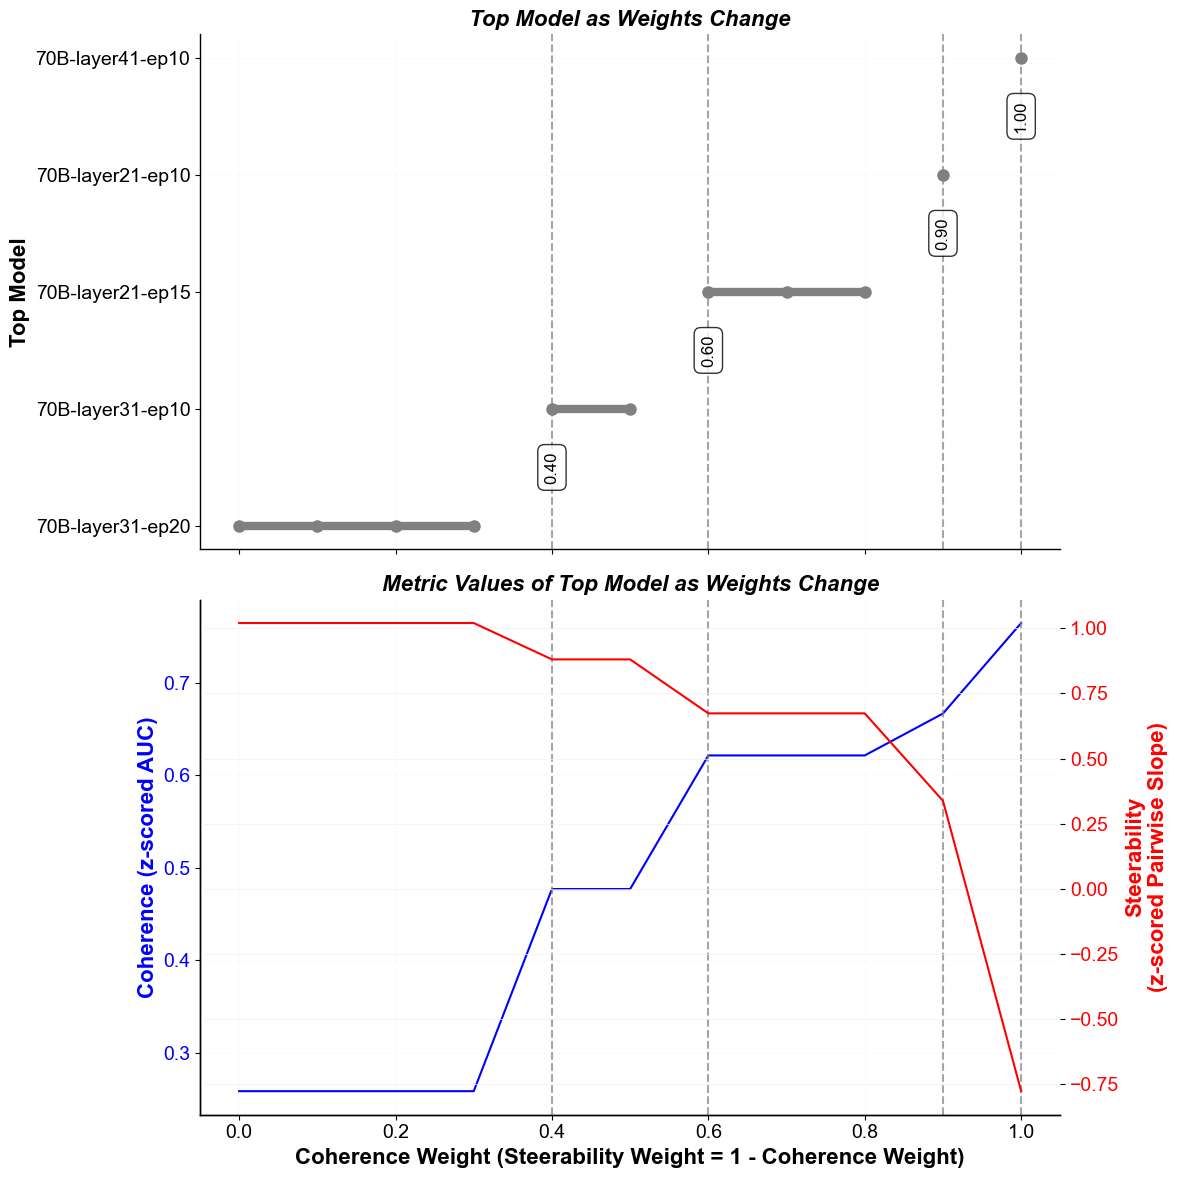

In [14]:
def analyze_weight_sensitivity(metrics_df, weight_steps=11, figsize=(12, 12)):
    """
    Analyze how the top model changes as we vary the weights between coherence and steerability.
    """
    coherence_weights = np.linspace(0, 1, weight_steps)

    results = []

    for coherence_weight in coherence_weights:
        steerability_weight = 1 - coherence_weight

        ranked_df = select_optimal_model_layers(
            metrics_df, coherence_weight, steerability_weight
        )

        top_model = ranked_df.iloc[0]
        model = top_model["model"]
        layer = int(top_model["layer"])
        epoch = int(top_model["epoch"])
        param = "8B" if "8B" in model else "70B"

        results.append(
            {
                "coherence_weight": coherence_weight,
                "steerability_weight": steerability_weight,
                "top_model": f"{param}-layer{layer}-ep{epoch}",
                "auc": top_model["auc"],
                "pairwise_slope": top_model["pairwise_slope"],
                "auc_normalized": top_model["auc_normalized"],
                "pairwise_slope_normalized": top_model["pairwise_slope_normalized"],
                "score": top_model["score"],
            }
        )

    results_df = pd.DataFrame(results)

    prev_model = None
    transitions = []

    for i, row in results_df.iterrows():
        current_model = row["top_model"]
        if prev_model is not None and current_model != prev_model:
            transitions.append(row["coherence_weight"])
        prev_model = current_model

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    unique_models = results_df["top_model"].unique()

    y_positions = {model: i for i, model in enumerate(unique_models)}

    prev_model = results_df.iloc[0]["top_model"]
    segment_start = 0

    for i, row in results_df.iterrows():
        current_model = row["top_model"]

        if current_model != prev_model:
            segment_weights = results_df.iloc[segment_start:i]["coherence_weight"]
            segment_y = [y_positions[prev_model]] * len(segment_weights)

            ax1.plot(
                segment_weights,
                segment_y,
                "o-",
                linewidth=6,
                markersize=8,
                color="grey",
            )

            segment_start = i
            prev_model = current_model

    segment_weights = results_df.iloc[segment_start:]["coherence_weight"]
    segment_y = [y_positions[prev_model]] * len(segment_weights)

    ax1.plot(
        segment_weights,
        segment_y,
        "o-",
        linewidth=6,
        markersize=8,
        color="grey",
    )

    ax1.set_yticks(range(len(unique_models)))
    ax1.set_yticklabels(unique_models)
    ax1.set_title("Top Model as Weights Change", fontsize=16, fontstyle="italic")
    ax1.set_ylabel("Top Model", fontsize=16, fontweight="bold")
    ax1.tick_params(axis="both", which="major", labelsize=14)
    ax1.grid(True, alpha=0.3)

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    for i, t in enumerate(transitions):
        ax1.axvline(x=t, color="grey", linestyle="--", alpha=0.7)
        y_pos = i + 0.5
        ax1.text(
            t,
            y_pos,
            f"{t:.2f}",
            rotation=90,
            ha="center",
            va="center",
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8),
        )

    ax2.plot(
        results_df["coherence_weight"],
        results_df["auc_normalized"],
        "b-",
        label="Coherence\n(z-scored AUC)",
    )
    ax2.set_ylabel(
        "Coherence (z-scored AUC)", color="b", fontsize=16, fontweight="bold"
    )
    ax2.tick_params(axis="y", labelcolor="b", labelsize=14)

    ax2_twin = ax2.twinx()
    ax2_twin.plot(
        results_df["coherence_weight"],
        results_df["pairwise_slope_normalized"],
        "r-",
        label="Steerability (z-scored)",
    )
    ax2_twin.set_ylabel(
        "Steerability\n(z-scored Pairwise Slope)",
        color="r",
        fontsize=16,
        fontweight="bold",
    )
    ax2_twin.tick_params(axis="y", labelcolor="r", labelsize=14)

    ax2.set_title(
        "Metric Values of Top Model as Weights Change", fontsize=16, fontstyle="italic"
    )
    ax2.set_xlabel(
        "Coherence Weight (Steerability Weight = 1 - Coherence Weight)",
        fontsize=16,
        fontweight="bold",
    )
    ax2.tick_params(axis="x", which="major", labelsize=14)
    ax2.grid(True, alpha=0.3)

    ax2.spines["top"].set_visible(False)
    ax2_twin.spines["top"].set_visible(False)

    for t in transitions:
        ax2.axvline(x=t, color="grey", linestyle="--", alpha=0.7)

    plt.tight_layout()
    return results_df, fig


sensitivity_df, fig_sens = analyze_weight_sensitivity(metrics_df)
save_fig(fig_sens, FIGURE_DIR, "weight_sensitivity")
plt.show()